Получение исходных данных

In [35]:
from basepolygon_class import GoalPolygon
from shapely.geometry import Polygon
place = GoalPolygon('Жилой комплекс «Одинцово-1»')
v = place.polygon

/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))
/opt/anaconda3/envs/tests/lib/python3.10/site-packages/osmnx/geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


Геометрическое упрощение

In [36]:
def get_xy(s):

    x, y = s.centroid.coords.xy
    return x[0], y[0]

Здесь полигон в нуле не от центра

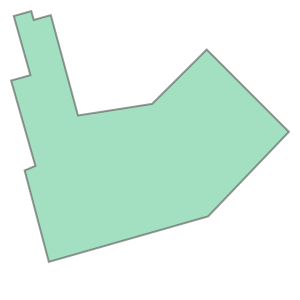

In [37]:
from shapely.affinity import translate

s = v.simplify(10, preserve_topology=True)
x, y, _, _ = v.bounds
#x, y = get_xy(s)
st = translate(s, 0-x, 0-y)

st

In [38]:
# убрать бы эту ебань
coor_list = (list(st.boundary.coords[0:len(st.boundary.coords) - 1]))

Декомпозиция периметра

In [39]:
import numpy as np
from math import pi, cos, sin

target = pi/2
basis = np.array([[1, 0, 0],[0, 1, 0]])
tolerance=0.75

In [40]:
transform = np.array(
    [
        [cos(target), -sin(target), 0],
        [sin(target), cos(target), 0],
        [0, 0, 1]
    ]
)

In [41]:
metric = np.complex(np.cross(basis[0], basis[1])[-1],
                             np.cross(basis[1], basis[0])[-1])


/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_6829/2402548898.py:1: DeprecationWarning: `np.complex` is a deprecated alias for the builtin `complex`. To silence this warning, use `complex` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.complex128` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  metric = np.complex(np.cross(basis[0], basis[1])[-1],


разбиение точек на группы по сегментам

In [42]:
from itertools import islice, cycle

def vec_search(point_list, key):
    cr = []
    n = list(islice(cycle(range(len(point_list))), 0, len(point_list) *2))
    for i in range(len(point_list)):
        v_one = [point_list[n[i]][0] - point_list[n[i + 1]][0], point_list[n[i]][1] - point_list[n[i + 1]][1], 0]
        v_two = [point_list[n[i + 1]][0] - point_list[n[i + 2]][0], point_list[n[i + 1]][1] - point_list[n[i + 2]][1],0]
        v_o_norm, v_t_norm = v_one / np.linalg.norm(v_one), v_two / np.linalg.norm(v_two)
        if np.cross(v_o_norm, v_t_norm)[2] < key:
            cr.append(n[i + 1])
        else:
            pass
    cross = [*cr, cr[0] + cr[-1] + 1]
    double_points = [*range(len(point_list)), *range(len(point_list))]
    segments = [double_points[cross[c]:cross[c + 1]+1] for c in range(len(cross) - 1)]
    return segments

In [43]:
bb = vec_search(coor_list, 0.7)
print(bb)

[[1, 2, 3, 4], [4, 5, 6, 7], [7, 8], [8, 9, 10], [10, 11, 12, 13], [13, 0, 1]]


вектора разбитые по группам от исходных точек

In [63]:
def chains_base (point_list):
    key_val = vec_search(point_list, 0.7)
    vectors =[]
    for i in key_val:
        temp =[]
        for l in range(len(i)-1):
            vec = [point_list[i[l]][0] - point_list[i[l+1]][0], point_list[i[l]][1] - point_list[i[l+1]][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors


In [64]:
res_vec = chains_base(coor_list)
print(res_vec)

[[[40.27832240751013, 17.184793210588396], [-90.76909511670237, 342.689586349763], [-597.2236579991877, -170.50443049520254]], [[-302.8780582649051, -317.03347889892757], [308.1424075482064, -308.39204586390406], [204.62842559075216, 203.57871970254928]], [[278.06133277650224, 43.473096154630184]], [[101.89771133306203, -376.15734403952956], [63.9330358550651, 17.928993717767298]], [[9.30055009451462, -33.0232094200328], [65.70811673195567, 18.42902405373752], [-62.45231896225596, 221.67703934758902]], [[72.29789360892028, 20.2681416394189], [-90.92466560343746, 319.88111454155296]]]


SVD
Декомпозиция

# Это техническая часть для работы с локальными данными
import json

f = open("/Users/andrewastakhov/dumps/pl.json", "r")
points = json.load(f)['pts']

In [65]:
from scipy.linalg import svd
import numpy as np

A = np.asarray(res_vec)

/var/folders/l7/52t7xngd2973k8x9_y55rmyh0000gn/T/ipykernel_6829/1396746674.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  A = np.asarray(res_vec)


Пример с одной матрицей

In [66]:
a = np.asarray(A[0])

In [67]:
U, s, Vh=svd(a)

Получить Sigma из s Хуй знает зачем сайпи говорят что это полезно

In [68]:
sigma = np.zeros(a.shape)
for i in range(min(a.shape)):
            sigma[i, i] = s[i]
sigma

array([[622.66245335,   0.        ],
       [  0.        , 354.44628545],
       [  0.        ,   0.        ]])

А точно, как минимум для обратной проверки, "B" должно быть равно "a"

In [69]:
B = U @ sigma @ Vh

Теперь на торче
Класс треннируется на основе отсортированых данных выпуклой декомпозиции периметра


In [70]:
import torch
from polygon_division import vector_search, points_to_point_chain

In [71]:
class SvdItem:
    keys=["A", "U", "S", "Vh", "Sigma"]
    def __init__(self, m, collection=None, **kwargs):
        self.A = torch.tensor(m)
        self.collection=collection
        self.U = None
        self.S = None
        self.Vh = None
        self.Sigma = None
        self.svd(**kwargs)
        if collection is not None:
            self.id = f'{collection.id}:{len(collection.matrices)}'
            print(f'set item id: {self.id}')
            collection.A.append(self.A)



    def svd(self, **kwargs):
        U, S, Vh = torch.linalg.svd(self.A, **kwargs)
        Sigma = torch.diag(S)
        self.U, self.S, self.Vh, self.Sigma=U, S, Vh, Sigma
        print(self.U, self.S, self.Vh, self.Sigma)
        if self.collection:
            for v, k in zip([A, U, S, Vh, Sigma], self.__class__.keys):
                (self.collection.__dict__[k]).append(v)

        return U, S, Vh, Sigma
    def pack(self):
        self.collection.__dict__[self.__class__.__name__][self.collection.id]|={self.id:self}
        return self.id, self



class SvdPack:
    def __init__(self):
        self._matrices = []
        self.id = f'{0}:{0}'
        self.A, self.U, self.S, self.Vh, self.Sigma = [], [], [], [], []
        self.tree= {self.id:{}}



    @property
    def matrices(self):
        return self._matrices
    @matrices.setter
    def matrices(self, val, **kwargs):
        if len(val.shape) == 2:
            self._matrices.append(SvdItem(val, collection=self, **kwargs))
        else:
            for v in val:
                self._matrices.append(SvdItem(v, collection=self, **kwargs))


In [72]:
pck = SvdPack()

In [73]:
a_=np.asarray(res_vec, dtype=object)

In [74]:
len(a_.shape)

1

In [75]:
pck.matrices = a_

tensor([[-0.0699, -0.0142,  0.9975],
        [-0.0167, -0.9997, -0.0154],
        [ 0.9974, -0.0177,  0.0696]]) tensor([622.6624, 354.4463]) tensor([[-0.9588, -0.2842],
        [ 0.2842, -0.9588]]) tensor([[622.6624,   0.0000],
        [  0.0000, 354.4463]])
set item id: 0:0:0
tensor([[-0.8348,  0.0270,  0.5499],
        [-0.0416, -0.9990, -0.0140],
        [ 0.5490, -0.0346,  0.8351]]) tensor([525.0457, 435.8289]) tensor([[ 0.6711,  0.7413],
        [-0.7413,  0.6711]]) tensor([[525.0457,   0.0000],
        [  0.0000, 435.8289]])
set item id: 0:0:1
tensor([[-1.]]) tensor([281.4392]) tensor([[-0.9880, -0.1545],
        [-0.1545,  0.9880]]) tensor([[281.4392]])
set item id: 0:0:2
tensor([[-1.0000,  0.0016],
        [ 0.0016,  1.0000]]) tensor([389.7151,  66.3967]) tensor([[-0.2612,  0.9653],
        [ 0.9653,  0.2612]]) tensor([[389.7151,   0.0000],
        [  0.0000,  66.3967]])
set item id: 0:0:3
tensor([[ 1.4734e-01, -9.6023e-05,  9.8909e-01],
        [ 3.7345e-04,  1.0000e+00,  4.14

In [76]:
pck.matrices

In [77]:
pck.S

[tensor([622.6624, 354.4463]),
 tensor([525.0457, 435.8289]),
 tensor([281.4392]),
 tensor([389.7151,  66.3967]),
 tensor([232.8477,  68.2435]),
 tensor([332.5527,  75.0847])]

In [78]:
pck.Sigma

[tensor([[622.6624,   0.0000],
         [  0.0000, 354.4463]]),
 tensor([[525.0457,   0.0000],
         [  0.0000, 435.8289]]),
 tensor([[281.4392]]),
 tensor([[389.7151,   0.0000],
         [  0.0000,  66.3967]]),
 tensor([[232.8477,   0.0000],
         [  0.0000,  68.2435]]),
 tensor([[332.5527,   0.0000],
         [  0.0000,  75.0847]])]

VH

In [79]:
pck_vh = pck.Vh
pck_vh

[tensor([[-0.9588, -0.2842],
         [ 0.2842, -0.9588]]),
 tensor([[ 0.6711,  0.7413],
         [-0.7413,  0.6711]]),
 tensor([[-0.9880, -0.1545],
         [-0.1545,  0.9880]]),
 tensor([[-0.2612,  0.9653],
         [ 0.9653,  0.2612]]),
 tensor([[ 0.2713, -0.9625],
         [ 0.9625,  0.2713]]),
 tensor([[-0.2736,  0.9618],
         [ 0.9618,  0.2736]])]

на данный момент не нужно, но если какая-то из матриц зеркальна, то вот

In [80]:
def matricies_check(matricies_list):
    matrix_checked = []
    for i in matricies_list:
        if i[0][1]<0 and i[1][0]>0 or i[0][1]>0 and i[1][0]<0 :
            matrix_checked.append(i)
        else:
            #ii = np.fliplr(i)*(-1)
            i[1]*= -1
            matrix_checked.append(i)
    return matrix_checked



huy = matricies_check(pck_vh)
huy

[tensor([[-0.9588, -0.2842],
         [ 0.2842, -0.9588]]),
 tensor([[ 0.6711,  0.7413],
         [-0.7413,  0.6711]]),
 tensor([[-0.9880, -0.1545],
         [ 0.1545, -0.9880]]),
 tensor([[-0.2612,  0.9653],
         [-0.9653, -0.2612]]),
 tensor([[ 0.2713, -0.9625],
         [ 0.9625,  0.2713]]),
 tensor([[-0.2736,  0.9618],
         [-0.9618, -0.2736]])]

соответственно точки по паттерну

In [81]:
def transform_chains_fromvh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_tt = transform_chains_fromvh(bb, huy)

РАЗГРУППИРОВКА ТОЧЕК ПО ПАТТЕРНУ

In [82]:
def transform_chains_vh(chains, t):
    chains_t=[]
    for i, clust in enumerate(chains):
        _t=[]
        for j in clust:
            _ = t.Vh[i] @ np.asarray(coor_list[j])
            _t.append(np.asarray(_).tolist())
        chains_t.append(_t)
    return chains_t

p_t = transform_chains_vh(bb, pck)

ЦЕПОЧКИ ВЕКТОРОВ (ВХОДЯТ ТОЧКИ С ЗАДАННЫМ ПАТТЕРНОМ)

In [83]:
def chains_ (point_list):
    vectors =[]
    for i in point_list:
        temp =[]
        for l in range(len(i)-1):
            vec = [i[l][0] - i[l+1][0], i[l][1] - i[l+1][1]]
            temp.append(vec)
        vectors.append(temp)
    return vectors

v_t = chains_(p_t)
# not transformed vec
v_ = res_vec
v_t

[[[-43.50147813085479, -5.028089906110267],
  [-10.374205974502729, -354.3551205167796],
  [621.0543540500247, -6.271404341340343]],
 [[-438.30005585001027, 11.762644912661301],
  [-21.81746072831288, -435.4094051197012],
  [288.253299440466, -15.069938197613055]],
 [[-281.4391726381694, -4.659170883769548e-06]],
 [[-389.7146551245596, -0.10331813025902647],
  [0.6064761715233544, -66.39664905876754]],
 [[34.307911309801284, -0.006548211910114787],
  [0.08694741239310133, 68.24352626965299],
  [-230.30634297894642, 0.024790084164806103]],
 [[-0.28601332461687434, -75.084628469242],
  [332.5525868091479, -0.06457252484048581]]]

замер угла между исходными векторами и транформированными

In [84]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))


ang =[]
for j, i in enumerate(v_t):
    for ind, val in enumerate(i):
        ang.append(angle_between(val, v_[j][ind]))
        break

print(ang)



[2.8533979930661495, 0.8350593062280169, 2.9865046080782, 1.8350735010944388, 1.2960796257017295, 1.8479314037072352]


Clusters

In [85]:

scope = np.asarray(ang)/np.linalg.norm(ang)
r = np.round(scope*len(ang),0)
labels=[]
l = np.unique(r).tolist()
for i in r:
    labels.append(l.index(i))
print(labels)

[2, 0, 2, 1, 1, 1]


In [86]:
for i in pck.Vh:
    for j in pck.Vh:

        print(torch.dist(i, j, p=4), torch.dist(i, j, p=2))
        print(i@j.T)
    print('end\n')


tensor(0.) tensor(0.)
tensor([[1., 0.],
        [0., 1.]])
tensor(2.0101) tensor(2.7234)
tensor([[-0.8542,  0.5200],
        [-0.5200, -0.8542]])
tensor(0.1544) tensor(0.1881)
tensor([[ 0.9912,  0.1327],
        [-0.1327,  0.9912]])
tensor(1.5208) tensor(2.0238)
tensor([[-0.0239,  0.9997],
        [-0.9997, -0.0239]])
tensor(1.4955) tensor(1.9865)
tensor([[ 0.0135, -0.9999],
        [ 0.9999,  0.0135]])
tensor(1.5146) tensor(2.0110)
tensor([[-0.0111,  0.9999],
        [-0.9999, -0.0111]])
end

tensor(2.0101) tensor(2.7234)
tensor([[-0.8542, -0.5200],
        [ 0.5200, -0.8542]])
tensor(0.) tensor(0.)
tensor([[1.0000, 0.0000],
        [0.0000, 1.0000]])
tensor(2.0137) tensor(2.6665)
tensor([[-0.7776, -0.6288],
        [ 0.6288, -0.7776]])
tensor(1.1097) tensor(1.3560)
tensor([[ 0.5403, -0.8415],
        [ 0.8415,  0.5403]])
tensor(2.0278) tensor(2.4751)
tensor([[-0.5315,  0.8471],
        [-0.8471, -0.5315]])
tensor(1.1243) tensor(1.3720)
tensor([[ 0.5294, -0.8484],
        [ 0.8484,  0

In [87]:
pck.U

[tensor([[-0.0699, -0.0142,  0.9975],
         [-0.0167, -0.9997, -0.0154],
         [ 0.9974, -0.0177,  0.0696]]),
 tensor([[-0.8348,  0.0270,  0.5499],
         [-0.0416, -0.9990, -0.0140],
         [ 0.5490, -0.0346,  0.8351]]),
 tensor([[-1.]]),
 tensor([[-1.0000,  0.0016],
         [ 0.0016,  1.0000]]),
 tensor([[ 1.4734e-01, -9.6023e-05,  9.8909e-01],
         [ 3.7345e-04,  1.0000e+00,  4.1436e-05],
         [-9.8909e-01,  3.6332e-04,  1.4734e-01]]),
 tensor([[-8.6005e-04,  1.0000e+00],
         [ 1.0000e+00,  8.6007e-04]])]

In [88]:
for i in pck.matrices:
    print(i.U[:,:2],'\n' ,i.S,'\n', i.Vh, '\n')

tensor([[-0.0699, -0.0142],
        [-0.0167, -0.9997],
        [ 0.9974, -0.0177]]) 
 tensor([622.6624, 354.4463]) 
 tensor([[-0.9588, -0.2842],
        [ 0.2842, -0.9588]]) 

tensor([[-0.8348,  0.0270],
        [-0.0416, -0.9990],
        [ 0.5490, -0.0346]]) 
 tensor([525.0457, 435.8289]) 
 tensor([[ 0.6711,  0.7413],
        [-0.7413,  0.6711]]) 

tensor([[-1.]]) 
 tensor([281.4392]) 
 tensor([[-0.9880, -0.1545],
        [ 0.1545, -0.9880]]) 

tensor([[-1.0000,  0.0016],
        [ 0.0016,  1.0000]]) 
 tensor([389.7151,  66.3967]) 
 tensor([[-0.2612,  0.9653],
        [-0.9653, -0.2612]]) 

tensor([[ 1.4734e-01, -9.6023e-05],
        [ 3.7345e-04,  1.0000e+00],
        [-9.8909e-01,  3.6332e-04]]) 
 tensor([232.8477,  68.2435]) 
 tensor([[ 0.2713, -0.9625],
        [ 0.9625,  0.2713]]) 

tensor([[-8.6005e-04,  1.0000e+00],
        [ 1.0000e+00,  8.6007e-04]]) 
 tensor([332.5527,  75.0847]) 
 tensor([[-0.2736,  0.9618],
        [-0.9618, -0.2736]]) 



In [ ]:
pck.tree

In [ ]:
pck.matrices